# Extract logistic regression model coefficients per CellProfiler feature

The coefficients from the machine learning model will either be positive (x > 0), where if the feature value increases, the more likely the feature is related to the Healthy cell type, negative (x < 0), where if the feature value increases, the more likely the feature is the Failing cell type, and zero (x = 0), where that feature has no impact on predicting if a cell is Healthy or Failing.

## Import libraries

In [1]:
from joblib import load
import pathlib
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Load in the models

In [2]:
# Output dir for coefficients data
coeff_dir = pathlib.Path("./coeff_data/")
coeff_dir.mkdir(parents=True, exist_ok=True)

# Directory of models
model_dir = pathlib.Path("./models/").resolve(strict=True)

# Define expected model files (adjust names if your filenames differ)
model_files = {
    "all_hearts": "model_all_hearts_final_downsample.joblib",
    "DCM": "model_DCM_final_downsample.joblib",
    "HCM": "model_HCM_final_downsample.joblib",
}

# Load each model into a dict
models = {}
for key, fname in model_files.items():
    path = model_dir / fname
    try:
        models[key] = load(path)
        print(f"Loaded {key} from {path}")
    except Exception as e:
        print(f"Could not load {key} from {path}: {e}")

# Keep backward compatibility by setting `final_model` to the all_hearts model if available,
# otherwise pick the first successfully loaded model.
final_model = models.get("all_hearts") or (
    next(iter(models.values())) if models else None
)

if final_model is None:
    raise FileNotFoundError("No models were loaded. Check model_dir and filenames.")
else:
    # optional: print a brief summary for each loaded model
    for name, mdl in models.items():
        n_features = getattr(mdl, "n_features_in_", None)
        print(f"{name}: {type(mdl).__name__}, n_features_in_={n_features}")

Loaded all_hearts from /home/jenna/predicting_cardiac_fibrosis_etiologies/5.machine_learning/models/model_all_hearts_final_downsample.joblib
Loaded DCM from /home/jenna/predicting_cardiac_fibrosis_etiologies/5.machine_learning/models/model_DCM_final_downsample.joblib
Loaded HCM from /home/jenna/predicting_cardiac_fibrosis_etiologies/5.machine_learning/models/model_HCM_final_downsample.joblib
all_hearts: LogisticRegression, n_features_in_=973
DCM: LogisticRegression, n_features_in_=973
HCM: LogisticRegression, n_features_in_=973


## Collect coefficients from the model and match with the correct feature in a dataframe

In [3]:
# Dictionary to store coefficient DataFrames for later analysis
coefficients_data = {}

# Extract and save coefficients for each loaded model in `models`
for key, mdl in models.items():
    try:
        feature_names = getattr(mdl, "feature_names_in_", None)
        coefs = getattr(mdl, "coef_", None)

        if feature_names is None or coefs is None:
            print(
                f"Skipping {key}: model does not expose feature names or coefficients."
            )
            continue

        # Handle binary vs multiclass
        if coefs.ndim == 1 or coefs.shape[0] == 1:
            coef_values = coefs.flatten()
            if coef_values.shape[0] != len(feature_names):
                print(
                    f"Warning for {key}: #coeffs ({coef_values.shape[0]}) != #features ({len(feature_names)})"
                )
            df = pd.DataFrame({"Feature": feature_names, "Coefficient": coef_values})
        else:
            # Multiclass: one coefficient column per class
            classes = getattr(mdl, "classes_", list(range(coefs.shape[0])))
            df = pd.DataFrame({"Feature": feature_names})
            for i, cls in enumerate(classes):
                df[f"Coef_{cls}"] = coefs[i]

            if df.shape[0] != len(feature_names):
                print(
                    f"Warning for {key}: resulting df rows ({df.shape[0]}) != #features ({len(feature_names)})"
                )

        # Parse feature names into components
        split_cols = df["Feature"].str.split("_", n=4, expand=True)
        df["Compartment"] = split_cols[0]
        df["Feature_Type"] = split_cols[1]
        df["Measurement"] = split_cols[2]
        df["Channel"] = split_cols[3]

        # Add ranking column based on coefficient value (raw; most positive = rank 1)
        if "Coefficient" in df.columns:
            zero_mask = df["Coefficient"].to_numpy() == 0
            rng = np.random.default_rng()

            # If multiple zeros, break ties randomly so they don't all get the same rank
            if zero_mask.sum() > 1:
                tie_breaker = np.zeros(len(df))
                tie_breaker[zero_mask] = rng.random(zero_mask.sum())
                df["_tie"] = tie_breaker
                # sort by coefficient (desc) and tie (desc) then assign integer ranks
                df = df.sort_values(
                    by=["Coefficient", "_tie"], ascending=[False, False]
                ).reset_index(drop=True)
                df["Rank"] = df.index + 1
                df.drop(columns=["_tie"], inplace=True)
            else:
                df["Rank"] = df["Coefficient"].rank(ascending=False)
        else:
            # fallback for multiclass where "Coefficient" might not exist
            coef_cols = [c for c in df.columns if c.startswith("Coef_")]
            if coef_cols:
                df["Rank"] = df[coef_cols[0]].rank(ascending=False)
            else:
                df["Rank"] = range(1, len(df) + 1)

        # Save to CSV
        out_path = coeff_dir / f"{key}_coeffs.csv"
        df.to_csv(out_path, index=False)
        print(f"Saved coefficients for model '{key}' to {out_path}")

        # Store in memory for analysis
        coefficients_data[key] = df

    except Exception as e:
        print(f"Error processing model '{key}': {e}")

Saved coefficients for model 'all_hearts' to coeff_data/all_hearts_coeffs.csv
Saved coefficients for model 'DCM' to coeff_data/DCM_coeffs.csv
Saved coefficients for model 'HCM' to coeff_data/HCM_coeffs.csv


## Explore the coefficients

In [4]:
# Find the row with the highest coefficient value for the all_hearts model from coefficients_data
all_hearts_coeffs = coefficients_data.get("all_hearts")
if all_hearts_coeffs is None:
    raise ValueError("No coefficients data found for 'all_hearts' model.")

# Extract the feature and coefficient values
max_row = all_hearts_coeffs.loc[all_hearts_coeffs["Coefficient"].idxmax()]
max_feature = max_row["Feature"]
max_coefficient_value = max_row["Coefficient"]

# Print or use the result
print("Feature with the highest coefficient:", max_feature)
print("Coefficient value:", max_coefficient_value)

Feature with the highest coefficient: Cytoplasm_Correlation_Correlation_Actin_ER
Coefficient value: 0.6607060550119804


In [5]:
# Find the row with the most negative coefficient value for the all_hearts model from coefficients_data
all_hearts_coeffs = coefficients_data.get("all_hearts")
if all_hearts_coeffs is None:
    raise ValueError("No coefficients data found for 'all_hearts' model.")

# Extract the feature and coefficient values
min_row = all_hearts_coeffs.loc[all_hearts_coeffs["Coefficient"].idxmin()]
min_feature = min_row["Feature"]
min_coefficient_value = min_row["Coefficient"]

# Print or use the result
print("Feature with the most negative coefficient:", min_feature)
print("Coefficient value:", min_coefficient_value)

Feature with the most negative coefficient: Cells_Intensity_MinIntensityEdge_Actin
Coefficient value: -0.8724036415636564


In [6]:
all_hearts_coeffs_sorted = all_hearts_coeffs.sort_values(
    by="Coefficient", ascending=True
)
all_hearts_coeffs_sorted.head(10)

,Feature,Coefficient,Compartment,Feature_Type,Measurement,Channel,Rank
972,Cells_Intensity_MinIntensityEdge_Actin,-0.872404,Cells,Intensity,MinIntensityEdge,Actin,973
971,Cytoplasm_Intensity_LowerQuartileIntensity_Actin,-0.818071,Cytoplasm,Intensity,LowerQuartileIntensity,Actin,972
970,Nuclei_AreaShape_MajorAxisLength,-0.416390,Nuclei,AreaShape,MajorAxisLength,None,971
969,Cytoplasm_Texture_AngularSecondMoment_Mitochon...,-0.391288,Cytoplasm,Texture,AngularSecondMoment,Mitochondria,970
968,Nuclei_Correlation_Correlation_Hoechst_PM,-0.385123,Nuclei,Correlation,Correlation,Hoechst,969
967,Cytoplasm_Texture_InfoMeas1_PM_3_02_256,-0.370351,Cytoplasm,Texture,InfoMeas1,PM,968
966,Cells_Intensity_IntegratedIntensityEdge_PM,-0.343668,Cells,Intensity,IntegratedIntensityEdge,PM,967
965,Nuclei_Intensity_MinIntensity_Mitochondria,-0.308150,Nuclei,Intensity,MinIntensity,Mitochondria,966
964,Nuclei_RadialDistribution_MeanFrac_PM_3of4,-0.304143,Nuclei,RadialDistribution,MeanFrac,PM,965
963,Cells_Correlation_K_ER_Hoechst,-0.283368,Cells,Correlation,K,ER,964


In [7]:
all_hearts_coeffs_sorted = all_hearts_coeffs.sort_values(
    by="Coefficient", ascending=False
)
all_hearts_coeffs_sorted.head(10)

,Feature,Coefficient,Compartment,Feature_Type,Measurement,Channel,Rank
0,Cytoplasm_Correlation_Correlation_Actin_ER,0.660706,Cytoplasm,Correlation,Correlation,Actin,1
1,Cytoplasm_Texture_InverseDifferenceMoment_Acti...,0.503342,Cytoplasm,Texture,InverseDifferenceMoment,Actin,2
2,Cells_Texture_AngularSecondMoment_Actin_3_01_256,0.490867,Cells,Texture,AngularSecondMoment,Actin,3
3,Cytoplasm_Intensity_LowerQuartileIntensity_Hoe...,0.464377,Cytoplasm,Intensity,LowerQuartileIntensity,Hoechst,4
4,Cytoplasm_Granularity_1_Mitochondria,0.434064,Cytoplasm,Granularity,1,Mitochondria,5
5,Nuclei_RadialDistribution_RadialCV_Mitochondri...,0.316252,Nuclei,RadialDistribution,RadialCV,Mitochondria,6
6,Nuclei_Intensity_MinIntensity_Actin,0.313472,Nuclei,Intensity,MinIntensity,Actin,7
7,Cytoplasm_Texture_InverseDifferenceMoment_Acti...,0.311269,Cytoplasm,Texture,InverseDifferenceMoment,Actin,8
8,Cells_Granularity_1_Hoechst,0.305736,Cells,Granularity,1,Hoechst,9
9,Cytoplasm_Texture_Contrast_Actin_3_02_256,0.298686,Cytoplasm,Texture,Contrast,Actin,10


## Plot ranks by coefficient scatterplot per model

/tmp/ipykernel_478750/2471360764.py:29: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  ax = sns.scatterplot(


Saved scatterplot for model 'all_hearts' to coeff_data/all_hearts_rank_scatter.png


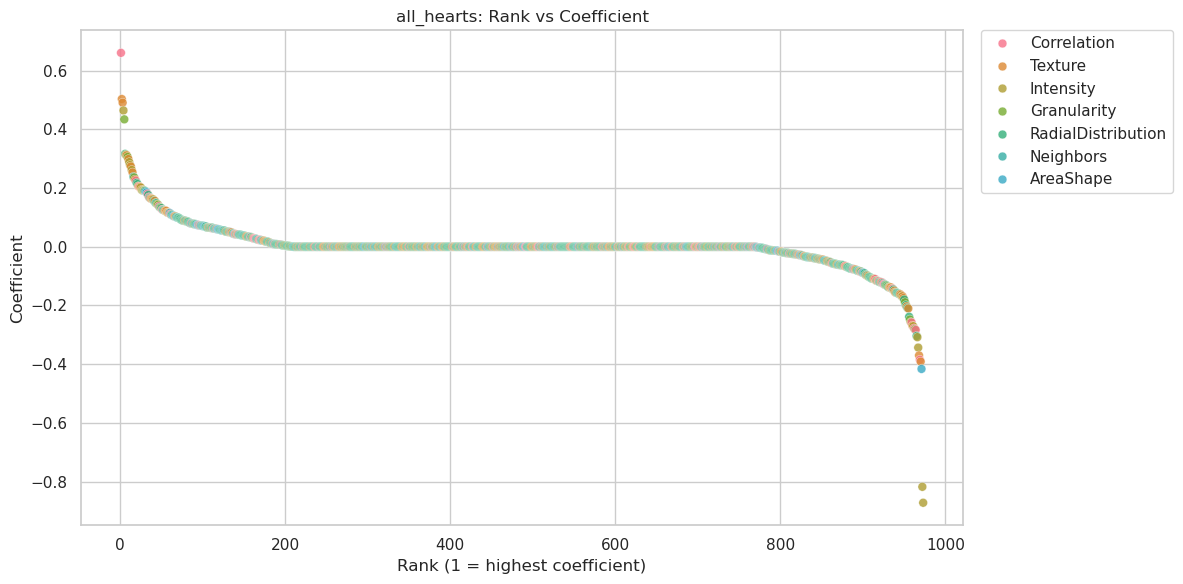

/tmp/ipykernel_478750/2471360764.py:29: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  ax = sns.scatterplot(


Saved scatterplot for model 'DCM' to coeff_data/DCM_rank_scatter.png


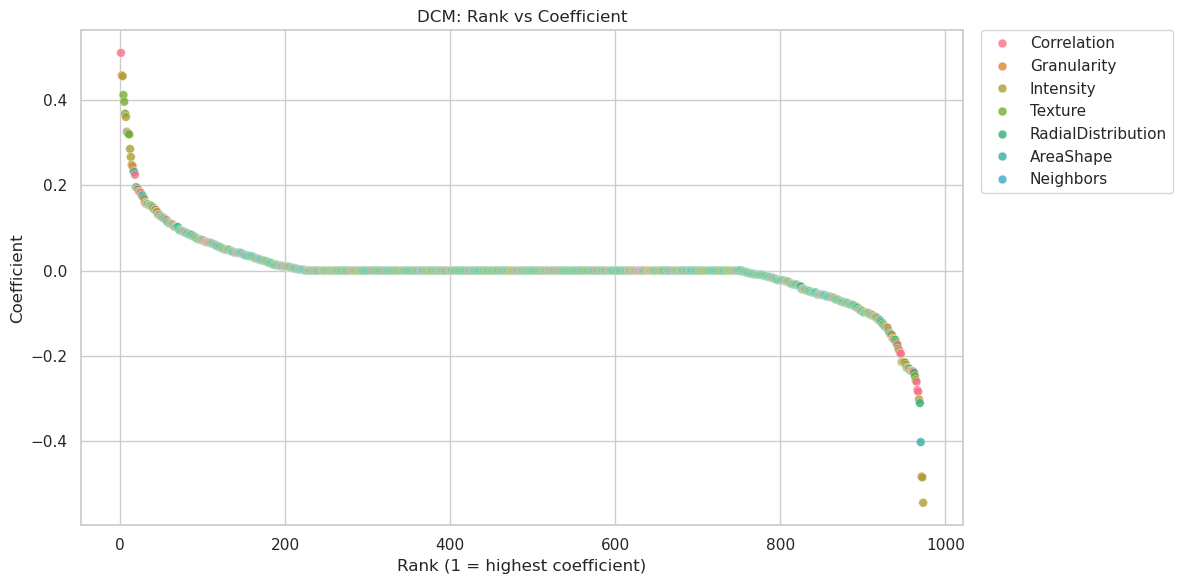

/tmp/ipykernel_478750/2471360764.py:29: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  ax = sns.scatterplot(


Saved scatterplot for model 'HCM' to coeff_data/HCM_rank_scatter.png


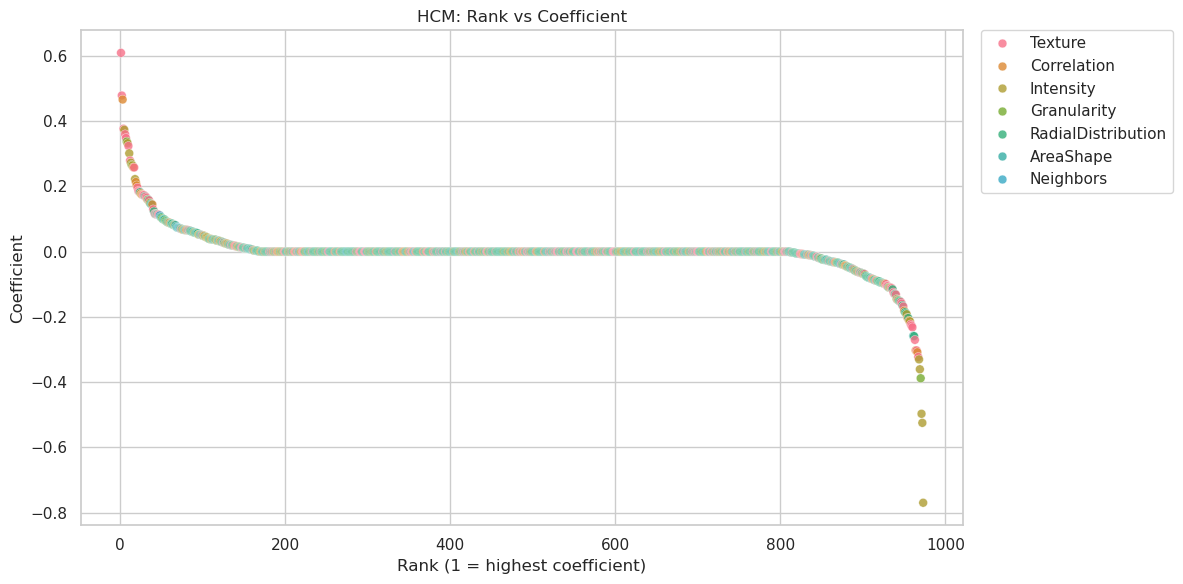

In [8]:
sns.set_theme(style="whitegrid")

for name, df in coefficients_data.items():
    df_plot = df.copy()

    # determine coefficient column to plot
    if "Coefficient" in df_plot.columns:
        coef_col = "Coefficient"
    else:
        coef_cols = [c for c in df_plot.columns if c.startswith("Coef_")]
        coef_col = coef_cols[0] if coef_cols else df_plot.columns[1]

    # ensure Rank exists
    if "Rank" not in df_plot.columns:
        df_plot["Rank"] = df_plot[coef_col].rank(ascending=False)

    # ensure Channel exists and has a sensible dtype for marker mapping
    if "Channel" not in df_plot.columns:
        df_plot["Channel"] = "NA"
    else:
        df_plot["Channel"] = df_plot["Channel"].fillna("NA").astype(str)

    plt.figure(figsize=(12, 6))
    # note: there may be many unique 'Feature_Type' values; this will create many colors
    # choose a qualitative palette with enough distinct colors for categories
    n_colors = max(10, df_plot["Feature_Type"].nunique())
    palette = sns.color_palette("husl", n_colors=n_colors)

    ax = sns.scatterplot(
        data=df_plot,
        x="Rank",
        y=coef_col,
        hue="Feature_Type",
        palette=palette,
        alpha=0.8,
        edgecolor="w",
        linewidth=0.3,
        legend="full",
        s=40,
    )

    ax.set_title(f"{name}: Rank vs Coefficient")
    ax.set_xlabel("Rank (1 = highest coefficient)")
    ax.set_ylabel("Coefficient")

    # move legend outside to avoid overlapping the plot (may be large)
    ax.legend(
        bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0, frameon=True
    )
    plt.tight_layout()

    out_path = coeff_dir / f"{name}_rank_scatter.png"
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    print(f"Saved scatterplot for model '{name}' to {out_path}")
    plt.show()